# The Basics of TOAD

Viel Spaß! 🎉


In [1]:
# Prerequisites
import matplotlib.pyplot as plt
import xarray as xr

# import TOAD
from toad import TOAD
import toad

plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (12, 6)

### Test data

Quick look at PISM simulation data of ice-sheet melt.


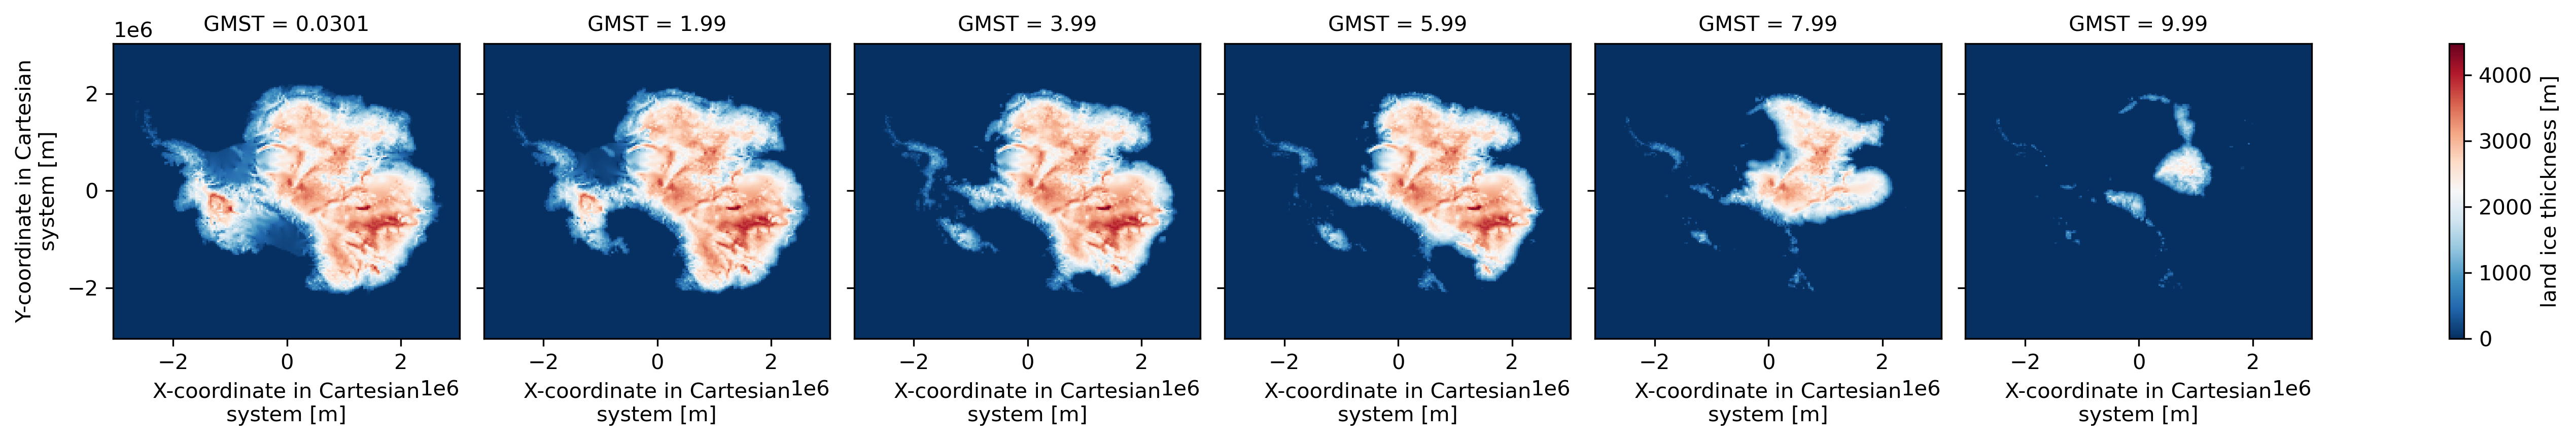

In [2]:
xr.load_dataset("test_data/garbe_2020_antarctica.nc").thk.sel(
    GMST=[0, 2, 4, 6, 8, 10], method="nearest"
).plot(col="GMST", cmap="RdBu_r")

### Init the TOAD object an .nc file

TOAD works on spatio-temporal data. If you time dimension is not called "time", you need to tell TOAD, as done below:


In [3]:
td = TOAD("test_data/garbe_2020_antarctica.nc", time_dim="GMST")
td.data = td.data.drop_vars(td.shift_vars)

### Step 1: Compute shifts

- First we need an **abrupt shifts detection method**: TOAD currently provides an implemention of `ASDETECT` ([Boulton & Lenton, 2019](https://ore.exeter.ac.uk/repository/handle/10871/40431)).
- See the [asdetect.py](../toad/shifts/methods/asdetect.py) docstring for a brief description.
- You can also implement your own shifts detection algorithm, see [shift_detection_methods.ipynb](../tutorials/shift_detection_methods.ipynb) for details.


In [4]:
from toad.shifts import ASDETECT

# define variable and method
td.compute_shifts(var="thk", method=ASDETECT(timescale=(0.5, 3.5)))

# ~12 seconds

INFO: New shifts variable thk_dts: min/mean/max=-1.000/-0.227/1.000 using 13901 grid cells. Skipped 61.5% grid cells: 0 NaN, 22199 constant.


#### Quick illustration of ASDETECT output


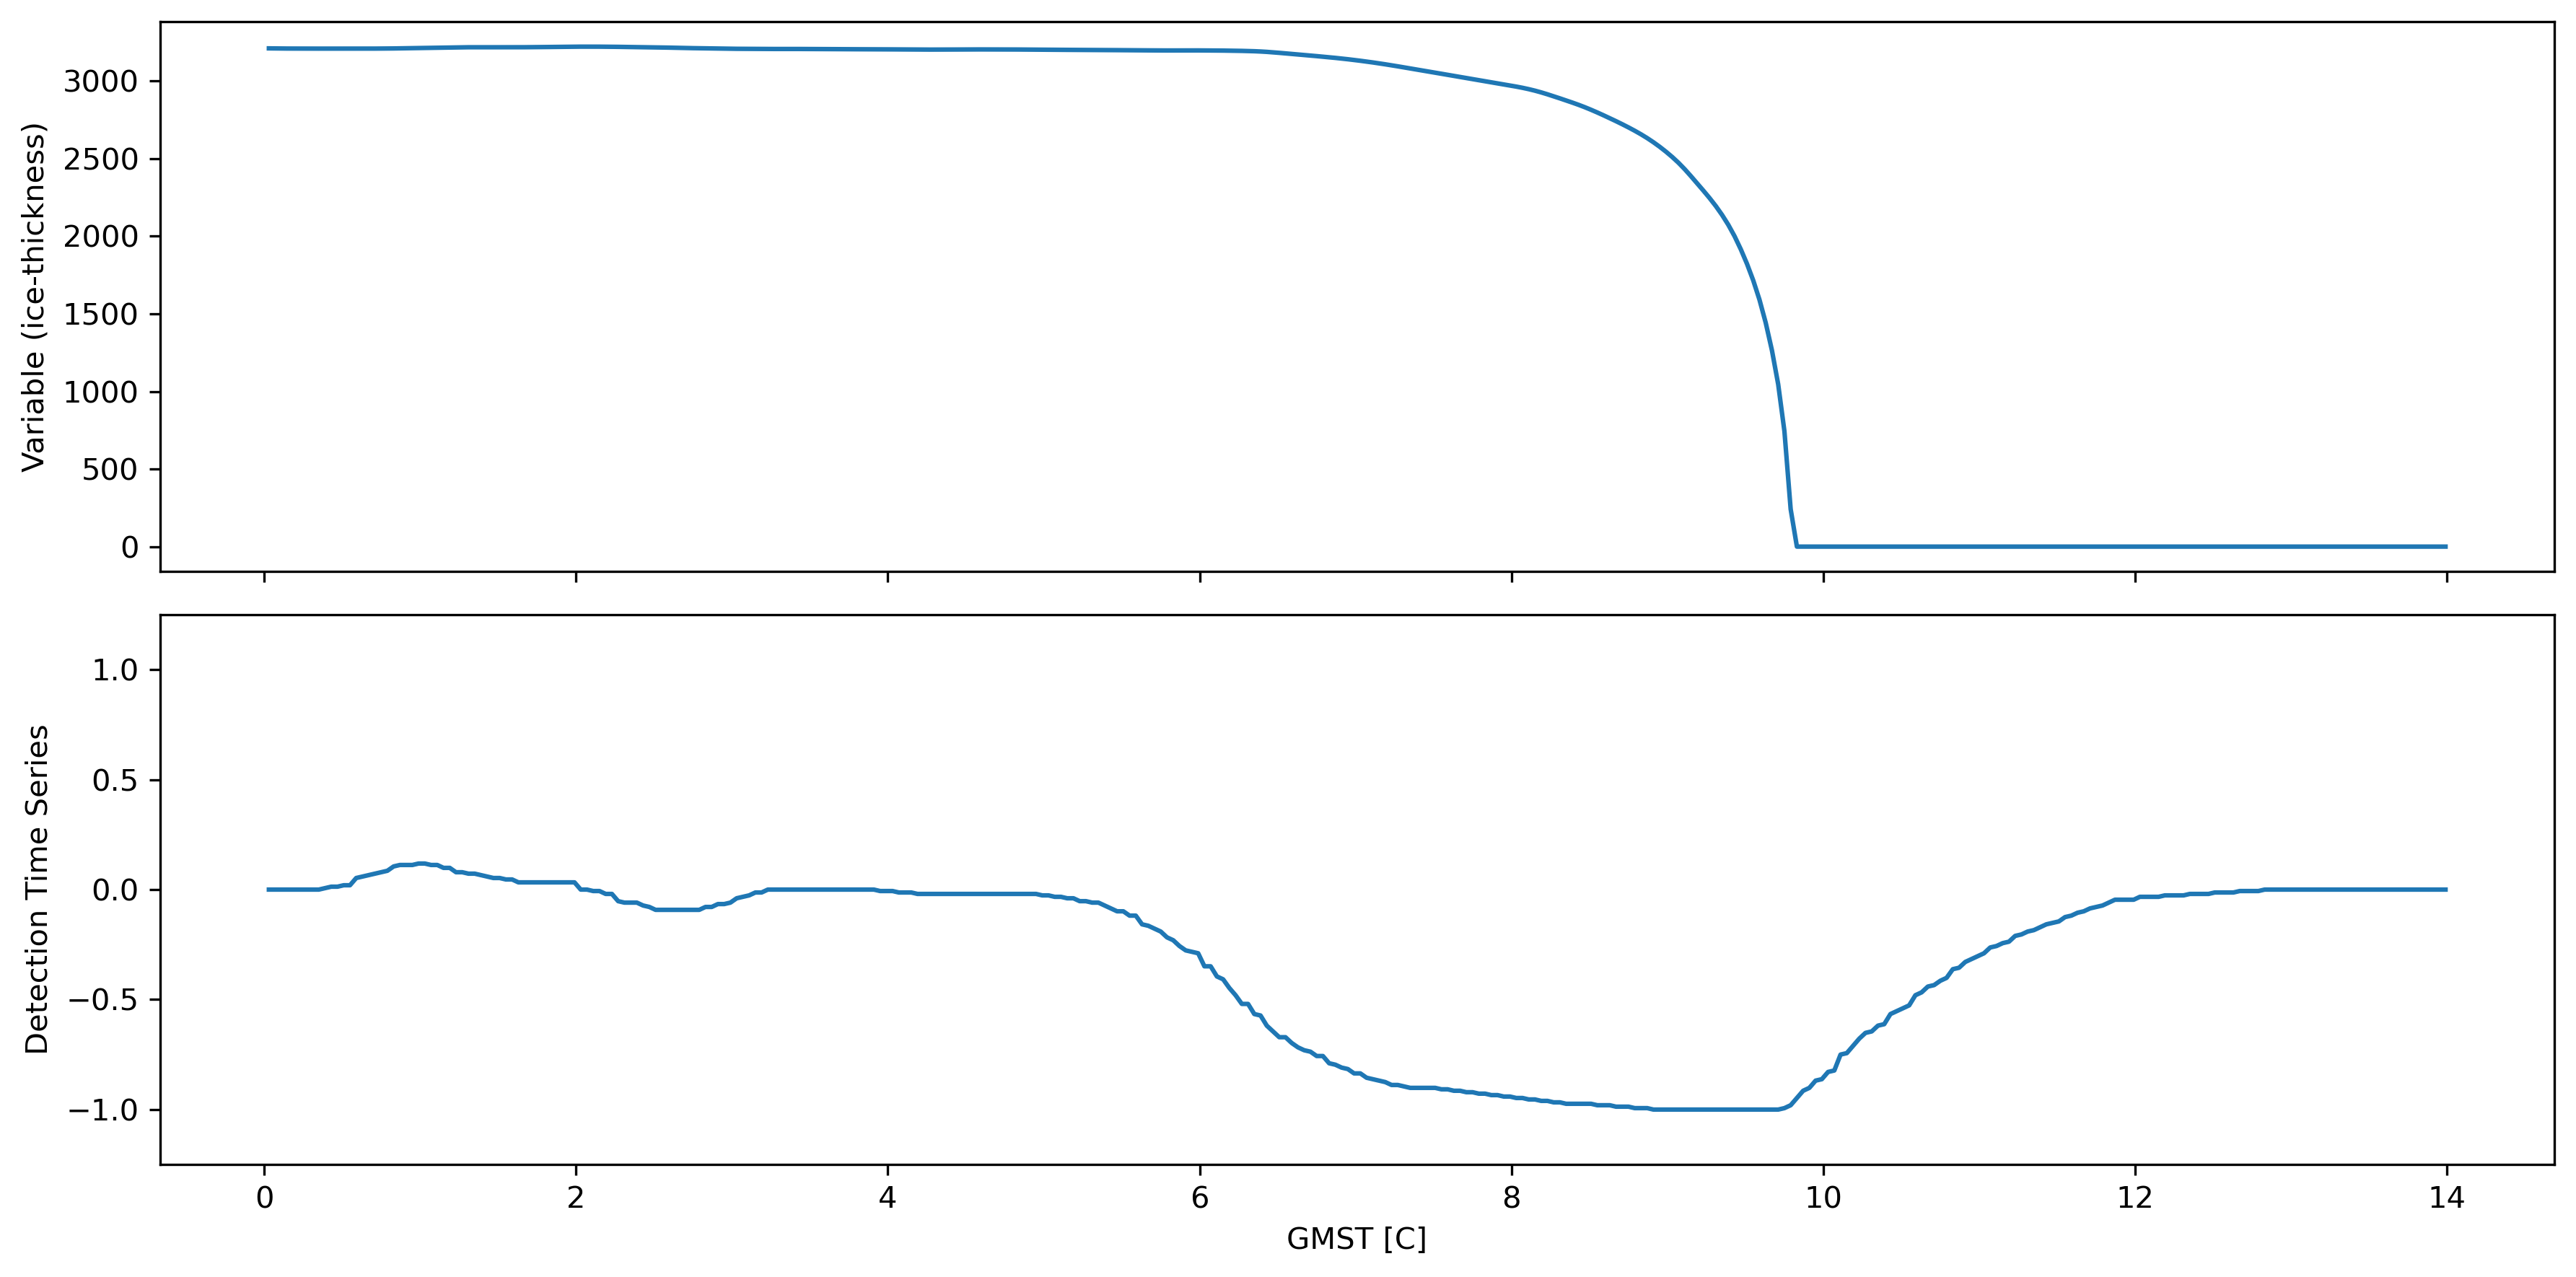

In [5]:
fig, axs = plt.subplots(2, sharex=True)
idx, idy = 100, 90
td.data.thk.isel(x=idx, y=idy).plot(ax=axs[0])
td.data.thk_dts.isel(x=idx, y=idy).plot(ax=axs[1])
axs[0].set_ylabel("Variable (ice-thickness)")
axs[1].set_ylabel("Detection Time Series")
axs[1].set_ylim(-1.25, 1.25)
axs[0].set_title("")
axs[1].set_title("")
axs[0].set_xlabel("")
fig.tight_layout()

## Step 2: Compute Clusters

- Now we need a **clustering method**: TOAD can take any clustering method from the [scikit-learn library](https://scikit-learn.org/stable/api/sklearn.cluster.html),
- We recommend using [HDBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html#sklearn.cluster.HDBSCAN) which has intuitive hyperparameters and supports clusters of different densities. Tip: For large datasets [fast_hdbscan](https://github.com/TutteInstitute/fast_hdbscan) can be significantly faster.
- You can also write your own clustering algorithm, see [clustering_methods.ipynb](../tutorials/clustering_methods.ipynb) for details.


In [6]:
from sklearn.cluster import HDBSCAN

td.data = td.data.drop_vars(td.cluster_vars)

td.compute_clusters(
    var="thk",  # reference your base variable, TOAD will find computed shifts for this variable
    method=HDBSCAN(min_cluster_size=15),
    time_weight=2.0,
)

INFO: New cluster variable thk_dts_cluster: Identified 79 clusters in 16,636 pts; Left 30.0% as noise (4,987 pts).


**Calling the TOAD object** gives you an overview of current computed variables:

For the "base variable" `thk`, we now have "shifts variable" `thk_dts` and "cluster variable" `thk_dts_cluster`.



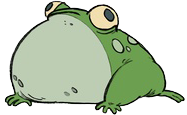

In [7]:
td

In [8]:
# You can find all method parameters used for the computation in the attributes, e.g:
td.data.thk_dts.attrs

{'standard_name': 'land_ice_thickness',
 'long_name': 'land ice thickness',
 'units': 'm',
 'pism_intent': 'model_state',
 'time_dim': 'GMST',
 'method_name': 'ASDETECT',
 'toad_version': '0.3',
 'base_variable': 'thk',
 'variable_type': 'shift',
 'method_ignore_nan_warnings': 'False',
 'method_lmax': '87',
 'method_lmin': '12',
 'method_segmentation': 'two_sided',
 'method_timescale': '(0.5, 3.5)'}

#### Let's **plot** the result:

TOAD supplies three plotting functions:

- `td.plot.overview()`

- `td.plot.cluster_map()`

- `td.plot.timeseries()`


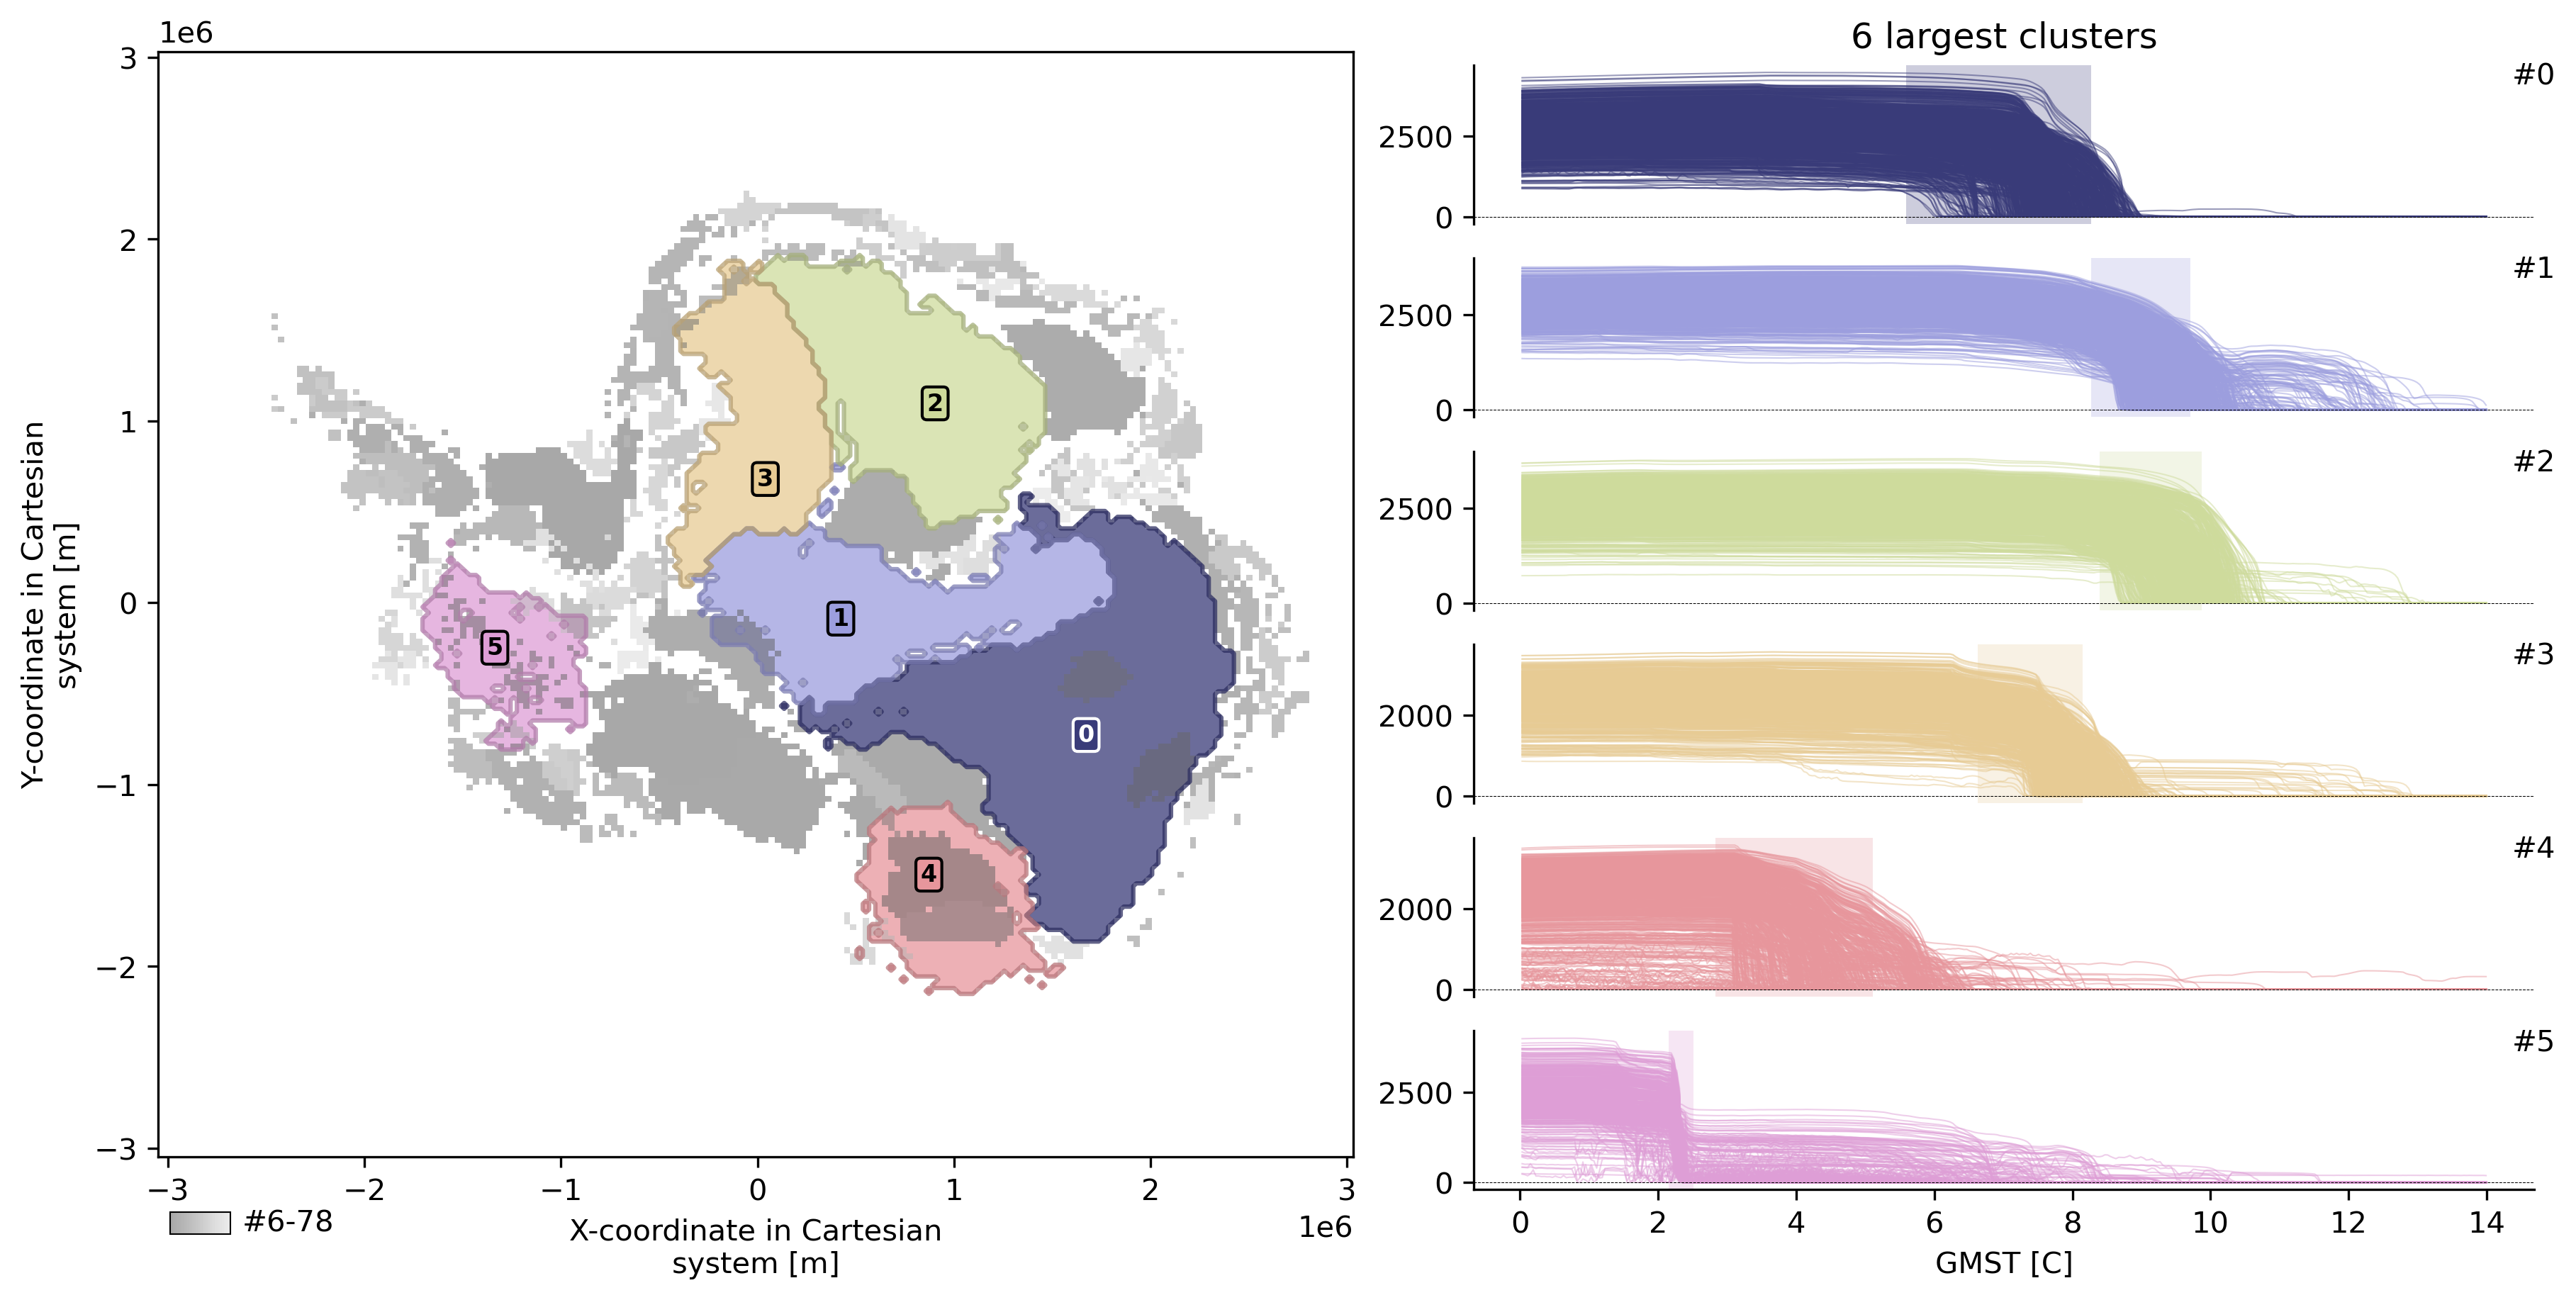

In [9]:
td.plot.overview();

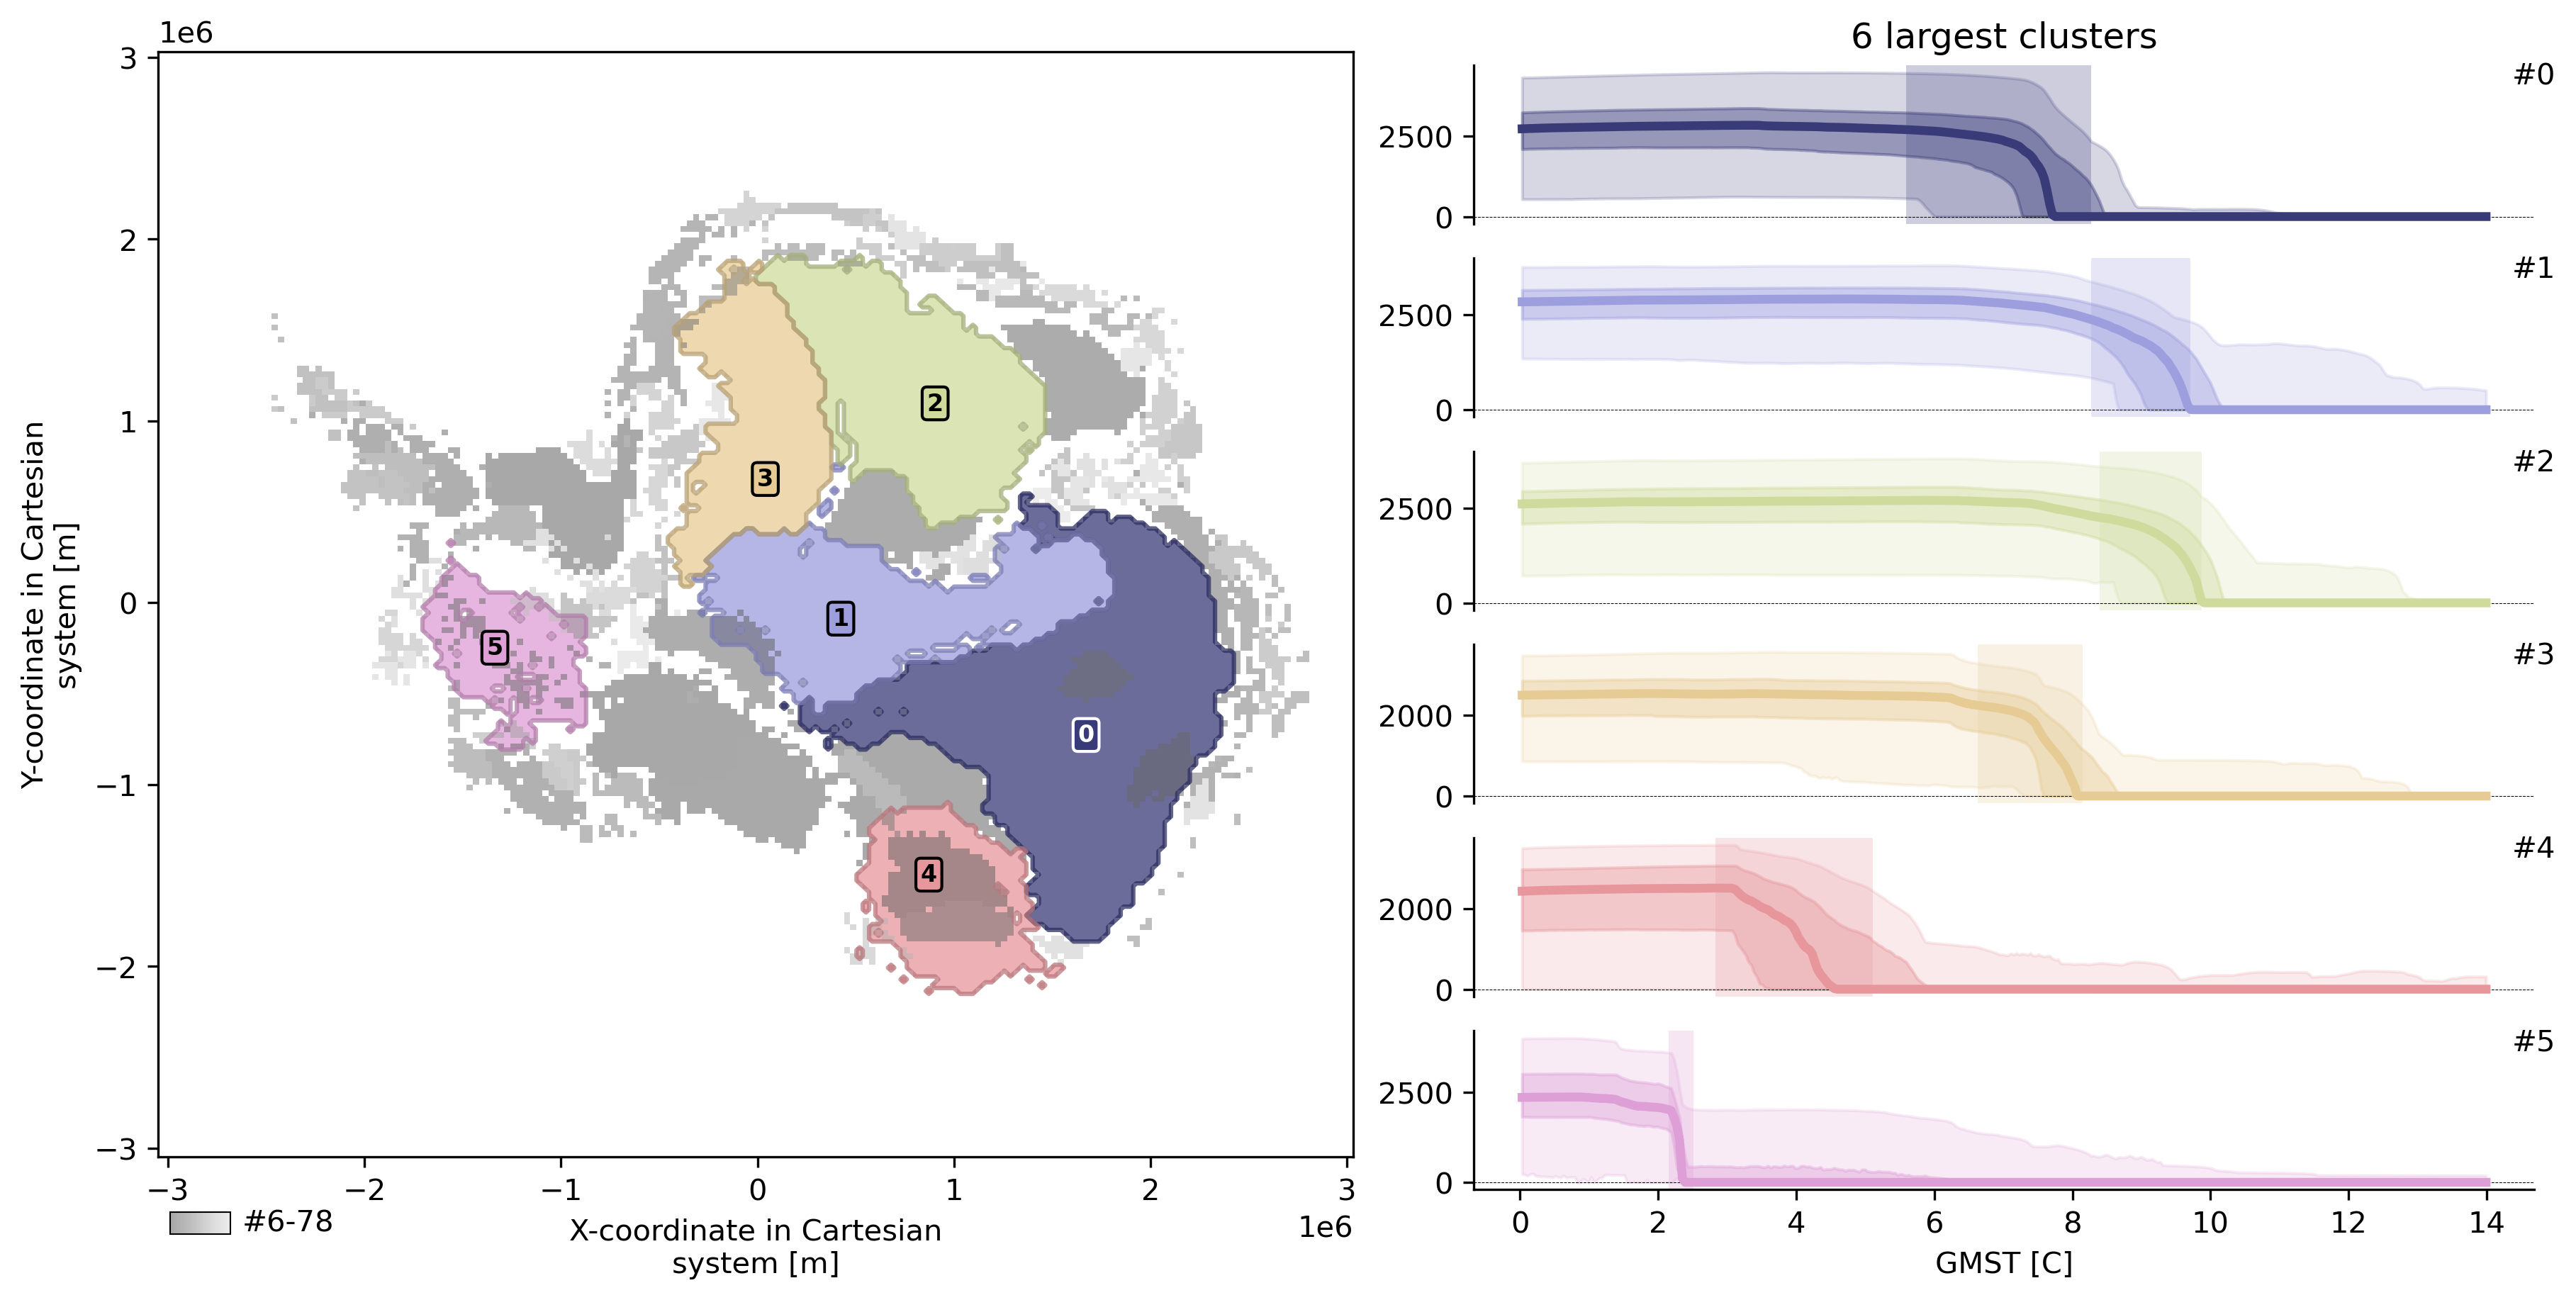

In [10]:
td.plot.overview(mode="aggregated");

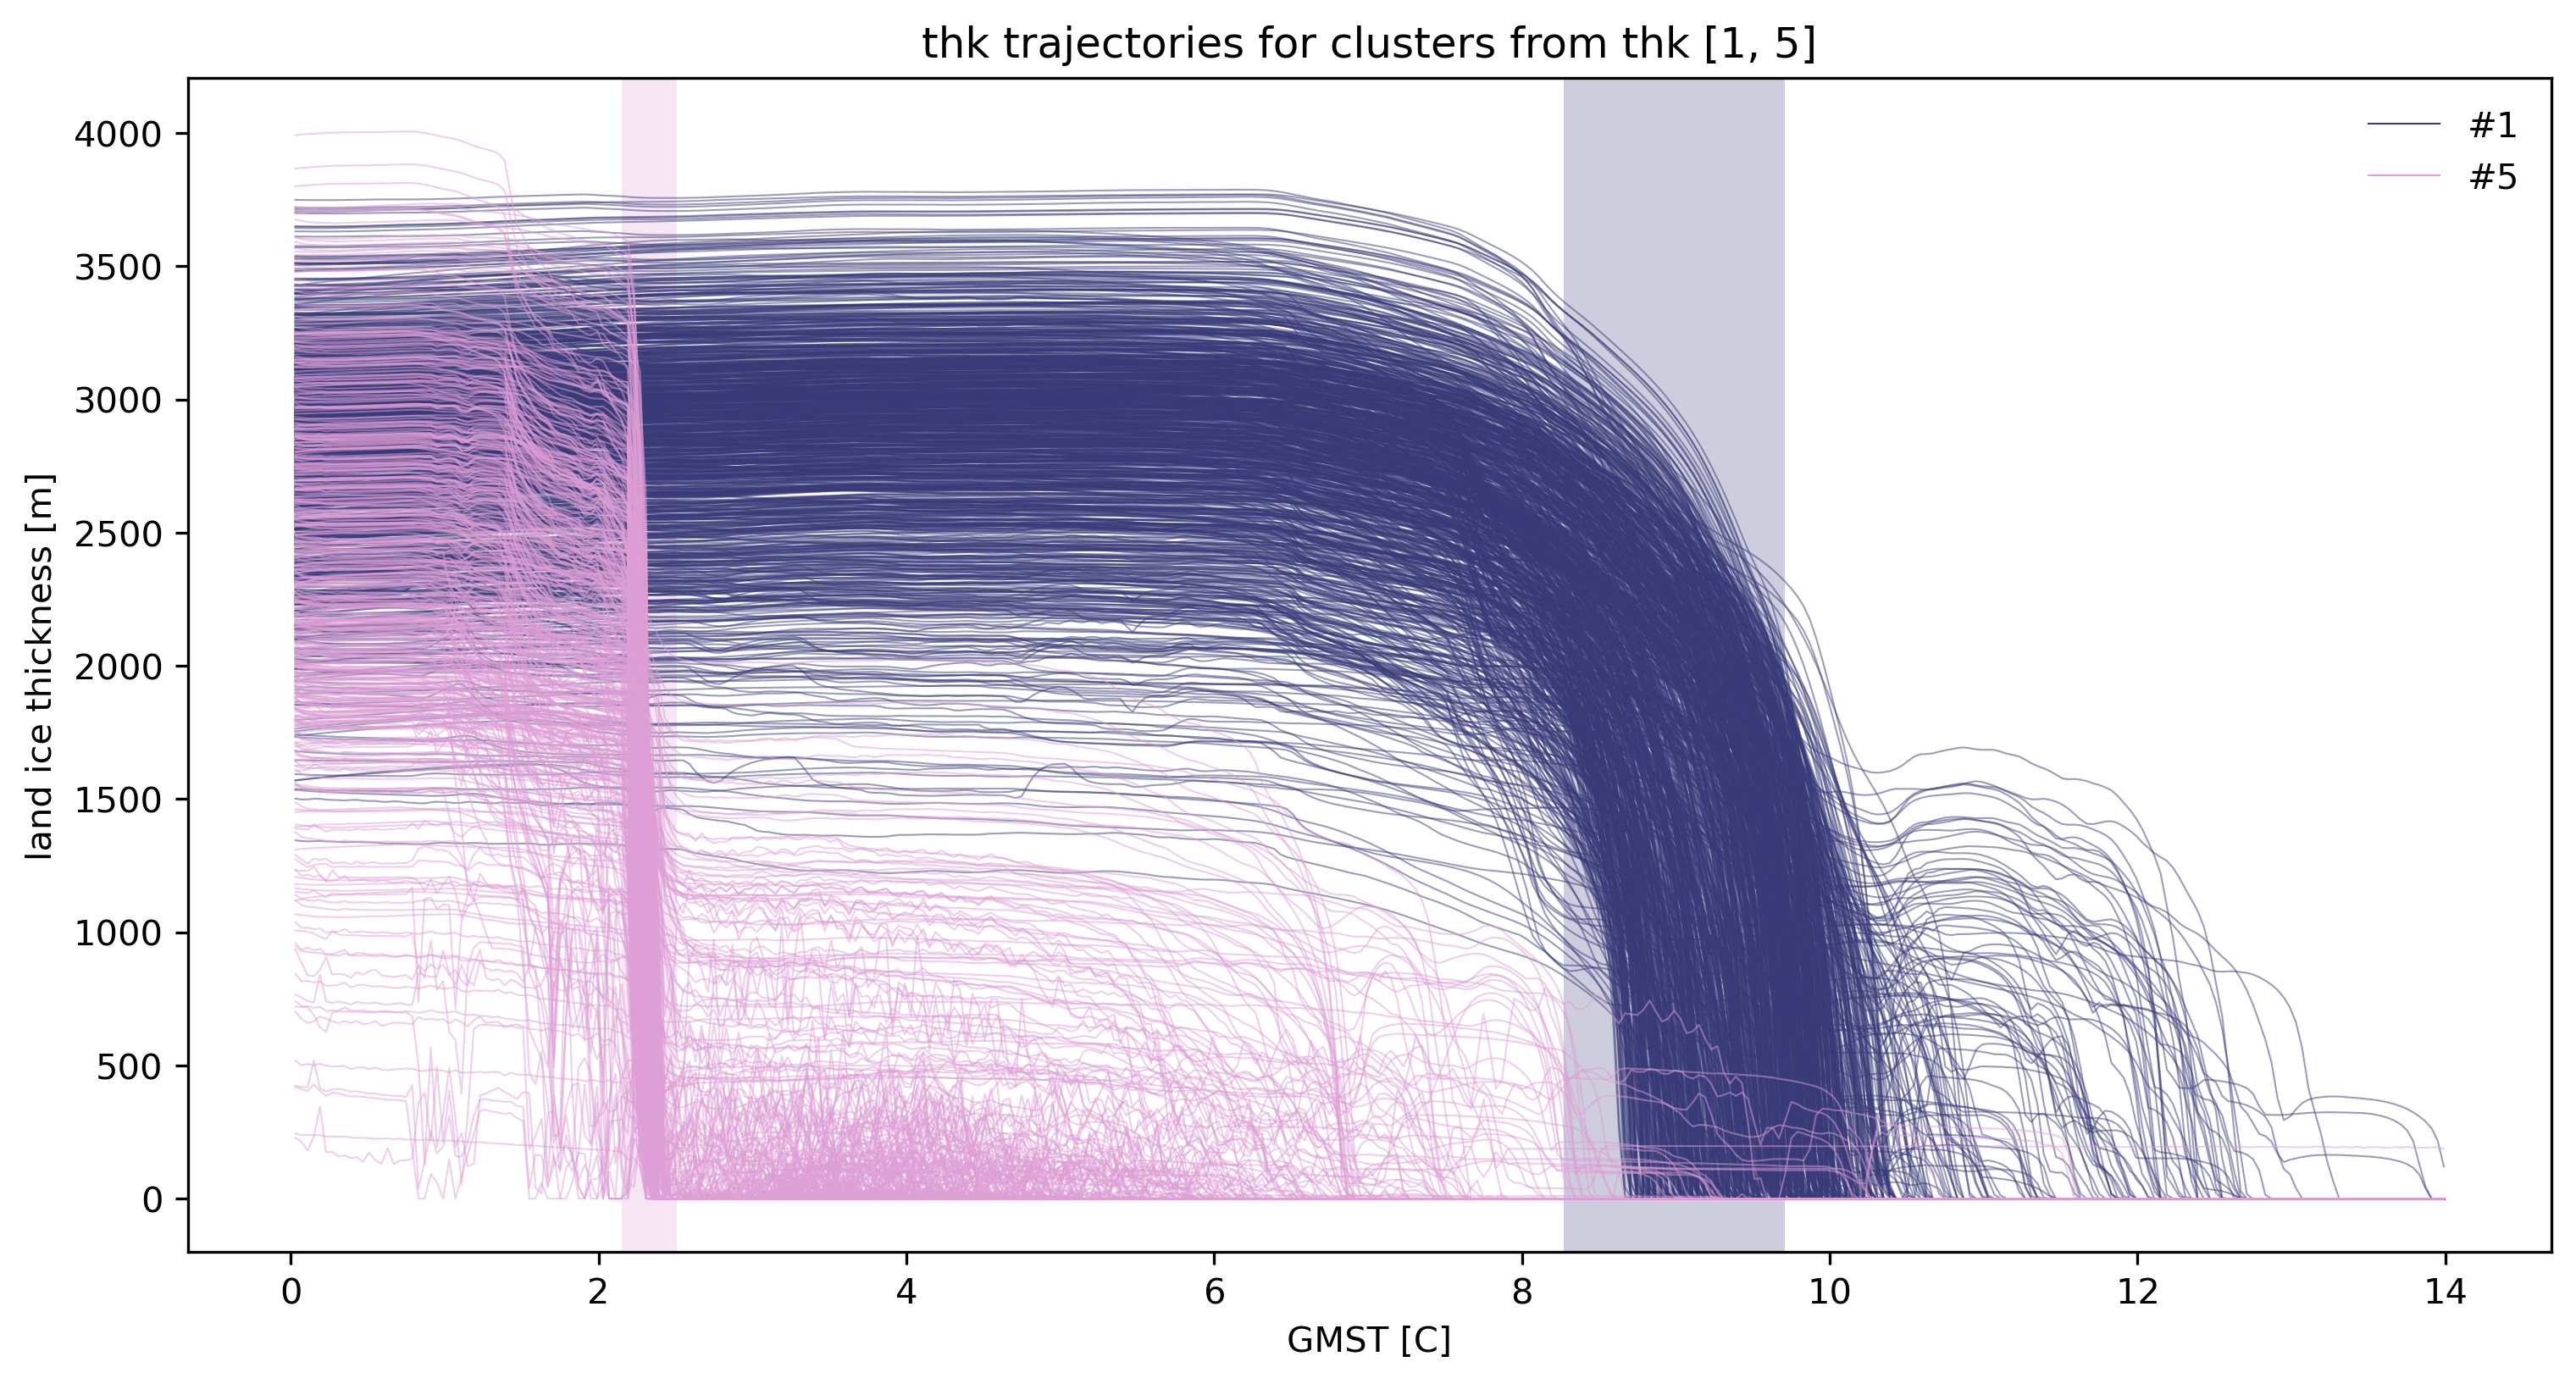

In [11]:
td.plot.timeseries(cluster_ids=[1, 5]);

Customize the map with the `map_style` param.


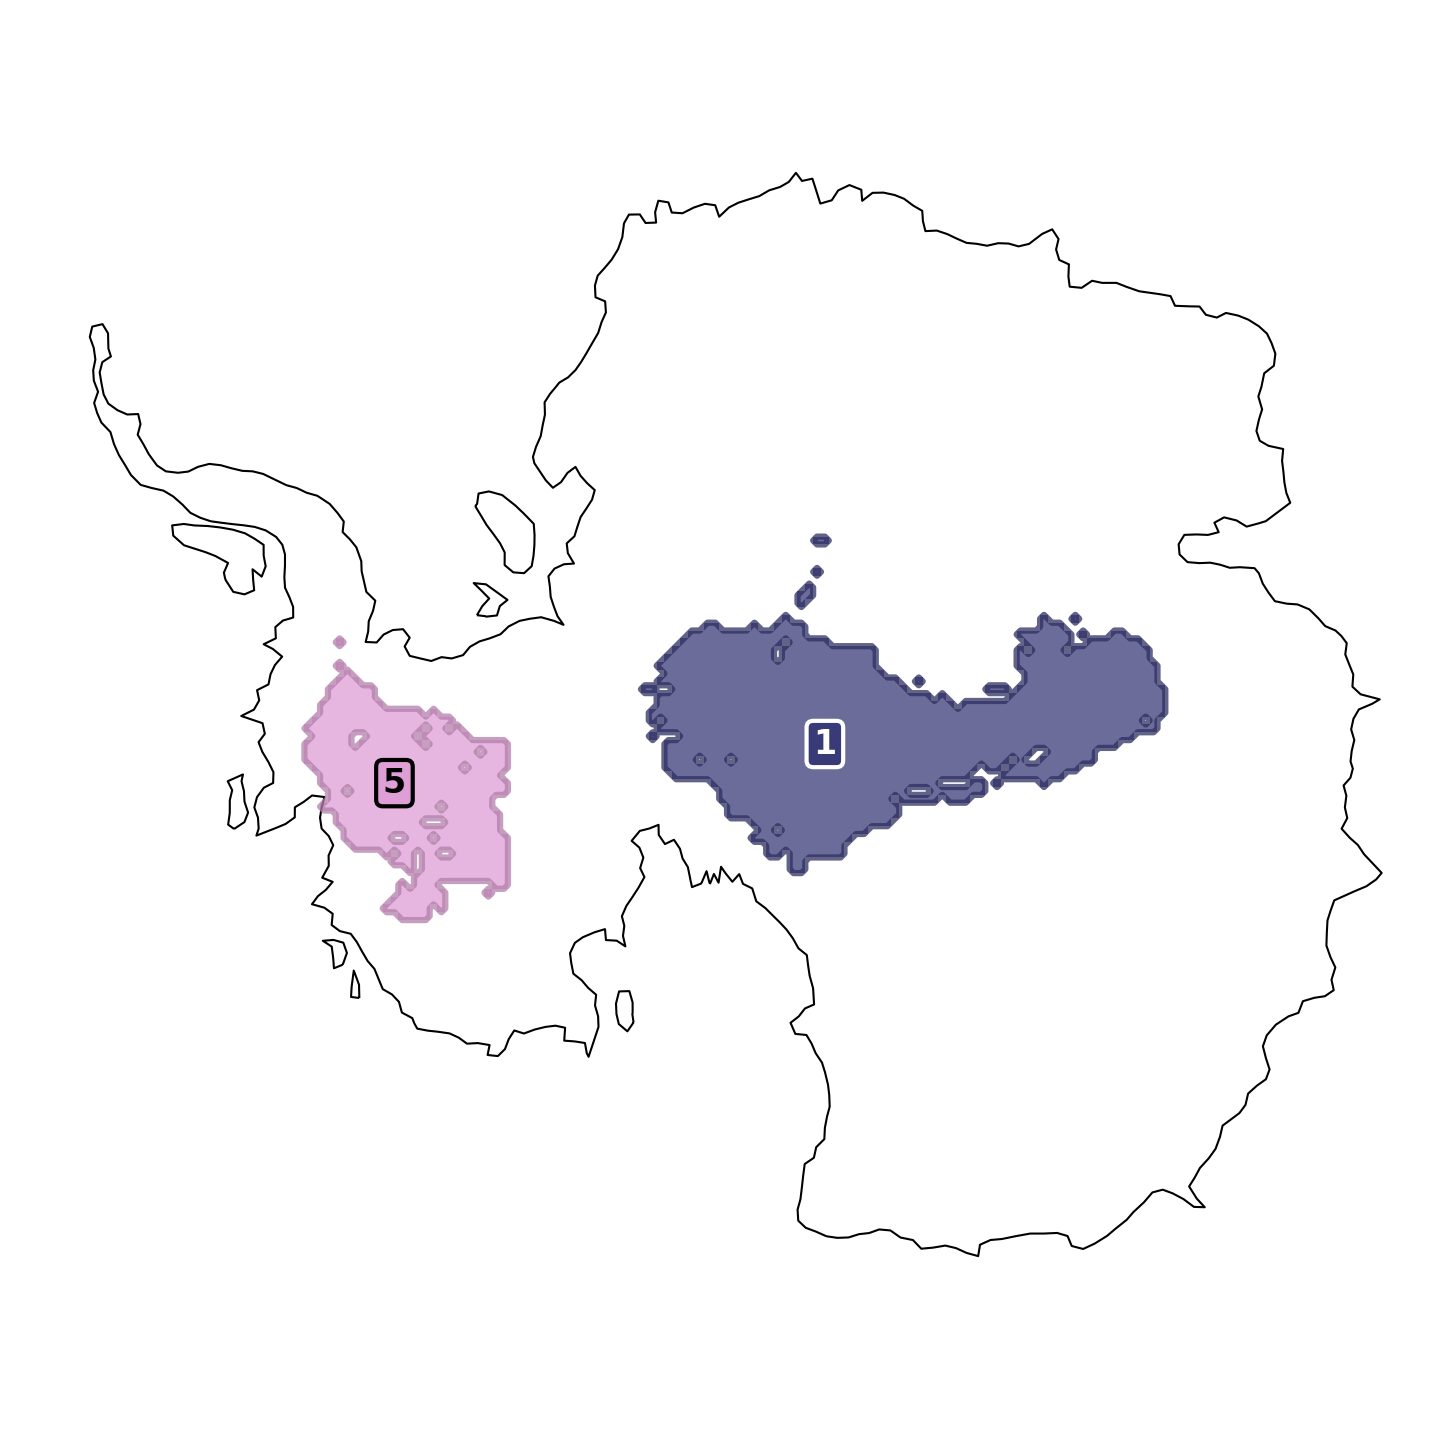

In [12]:
fig, ax = td.plot.cluster_map(
    cluster_ids=[1, 5],
    include_all_clusters=False,
    map_style=toad.MapStyle(projection="south_pole", grid_lines=False),
)
ax.set_axis_off()

We can also see a map of the time/forcing level of the maximum detected shift. This already gives a feeling for the structures that we see in the clusters.


(<Figure size 3600x1800 with 2 Axes>,
 <GeoAxes: title={'center': 'Time of maximum shift for thk'}, xlabel='x', ylabel='y'>)

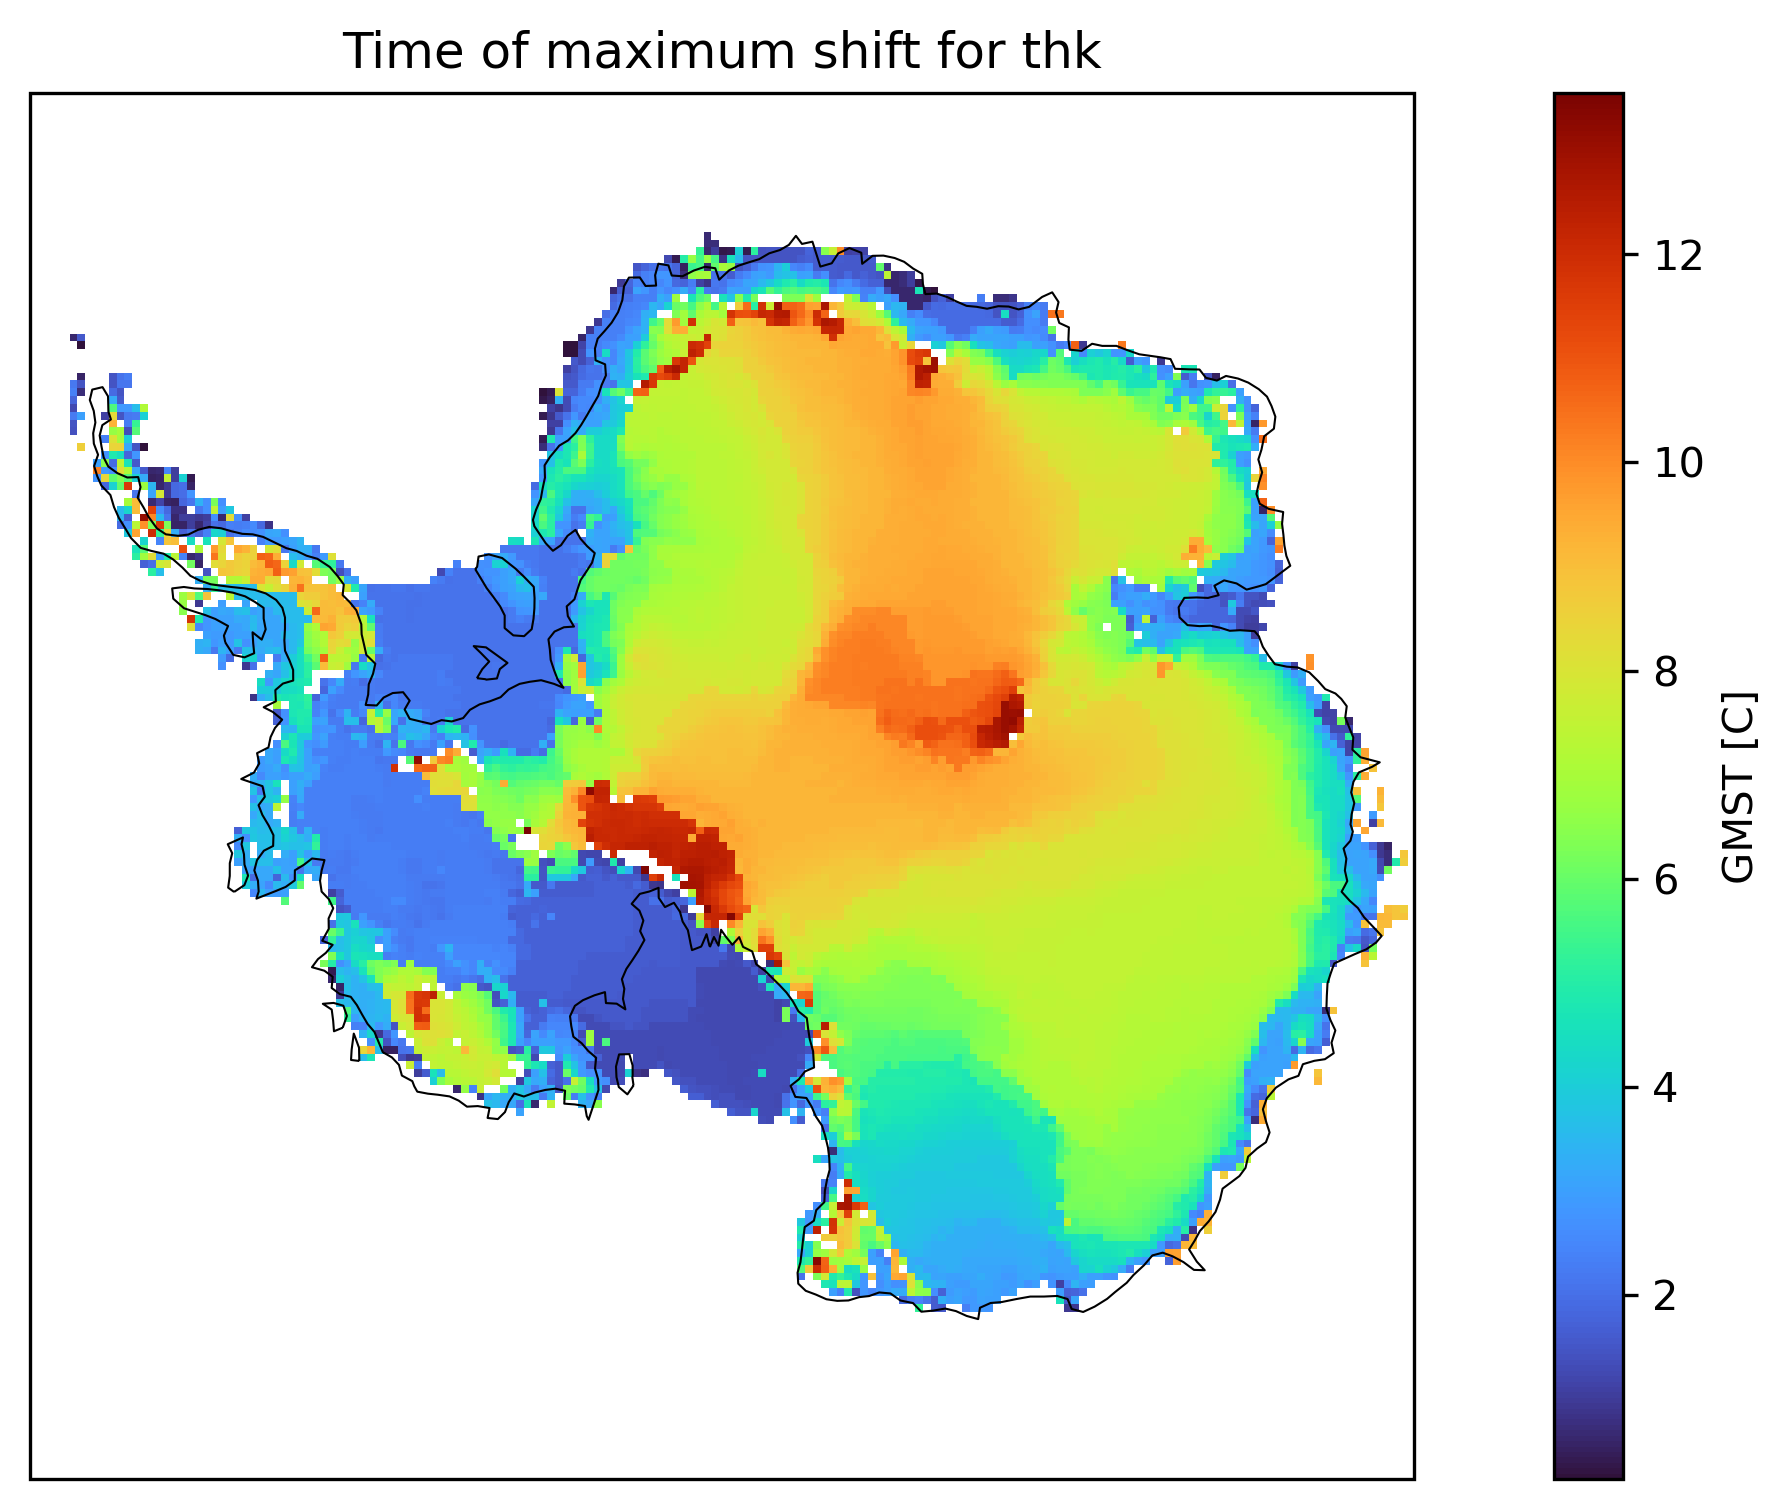

In [ ]:
td.plot.time_of_max_shift_map(
    "thk", map_style=toad.MapStyle(projection="south_pole", grid_lines=False)
)

#### Save your results


Save the dataset with the new additions using the `td.save()` function. This automatically adds compression.


In [23]:
# Use original path name with suffix
# td.save(suffix="_my_computed_toad_data")

# Use a different path name
# td.save(path="my_computed_toad_data.nc")

#### Export cluster masks


In [24]:
mask = td.get_cluster_mask_spatial("thk", cluster_id=1)
mask

<xarray.DataArray 'thk_dts_cluster' (y: 190, x: 190)> Size: 36kB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(190, 190))
Coordinates:
  * y        (y) float64 2kB -3.032e+06 -3e+06 ... 2.984e+06 3.016e+06
  * x        (x) float64 2kB -3.032e+06 -3e+06 ... 2.984e+06 3.016e+06

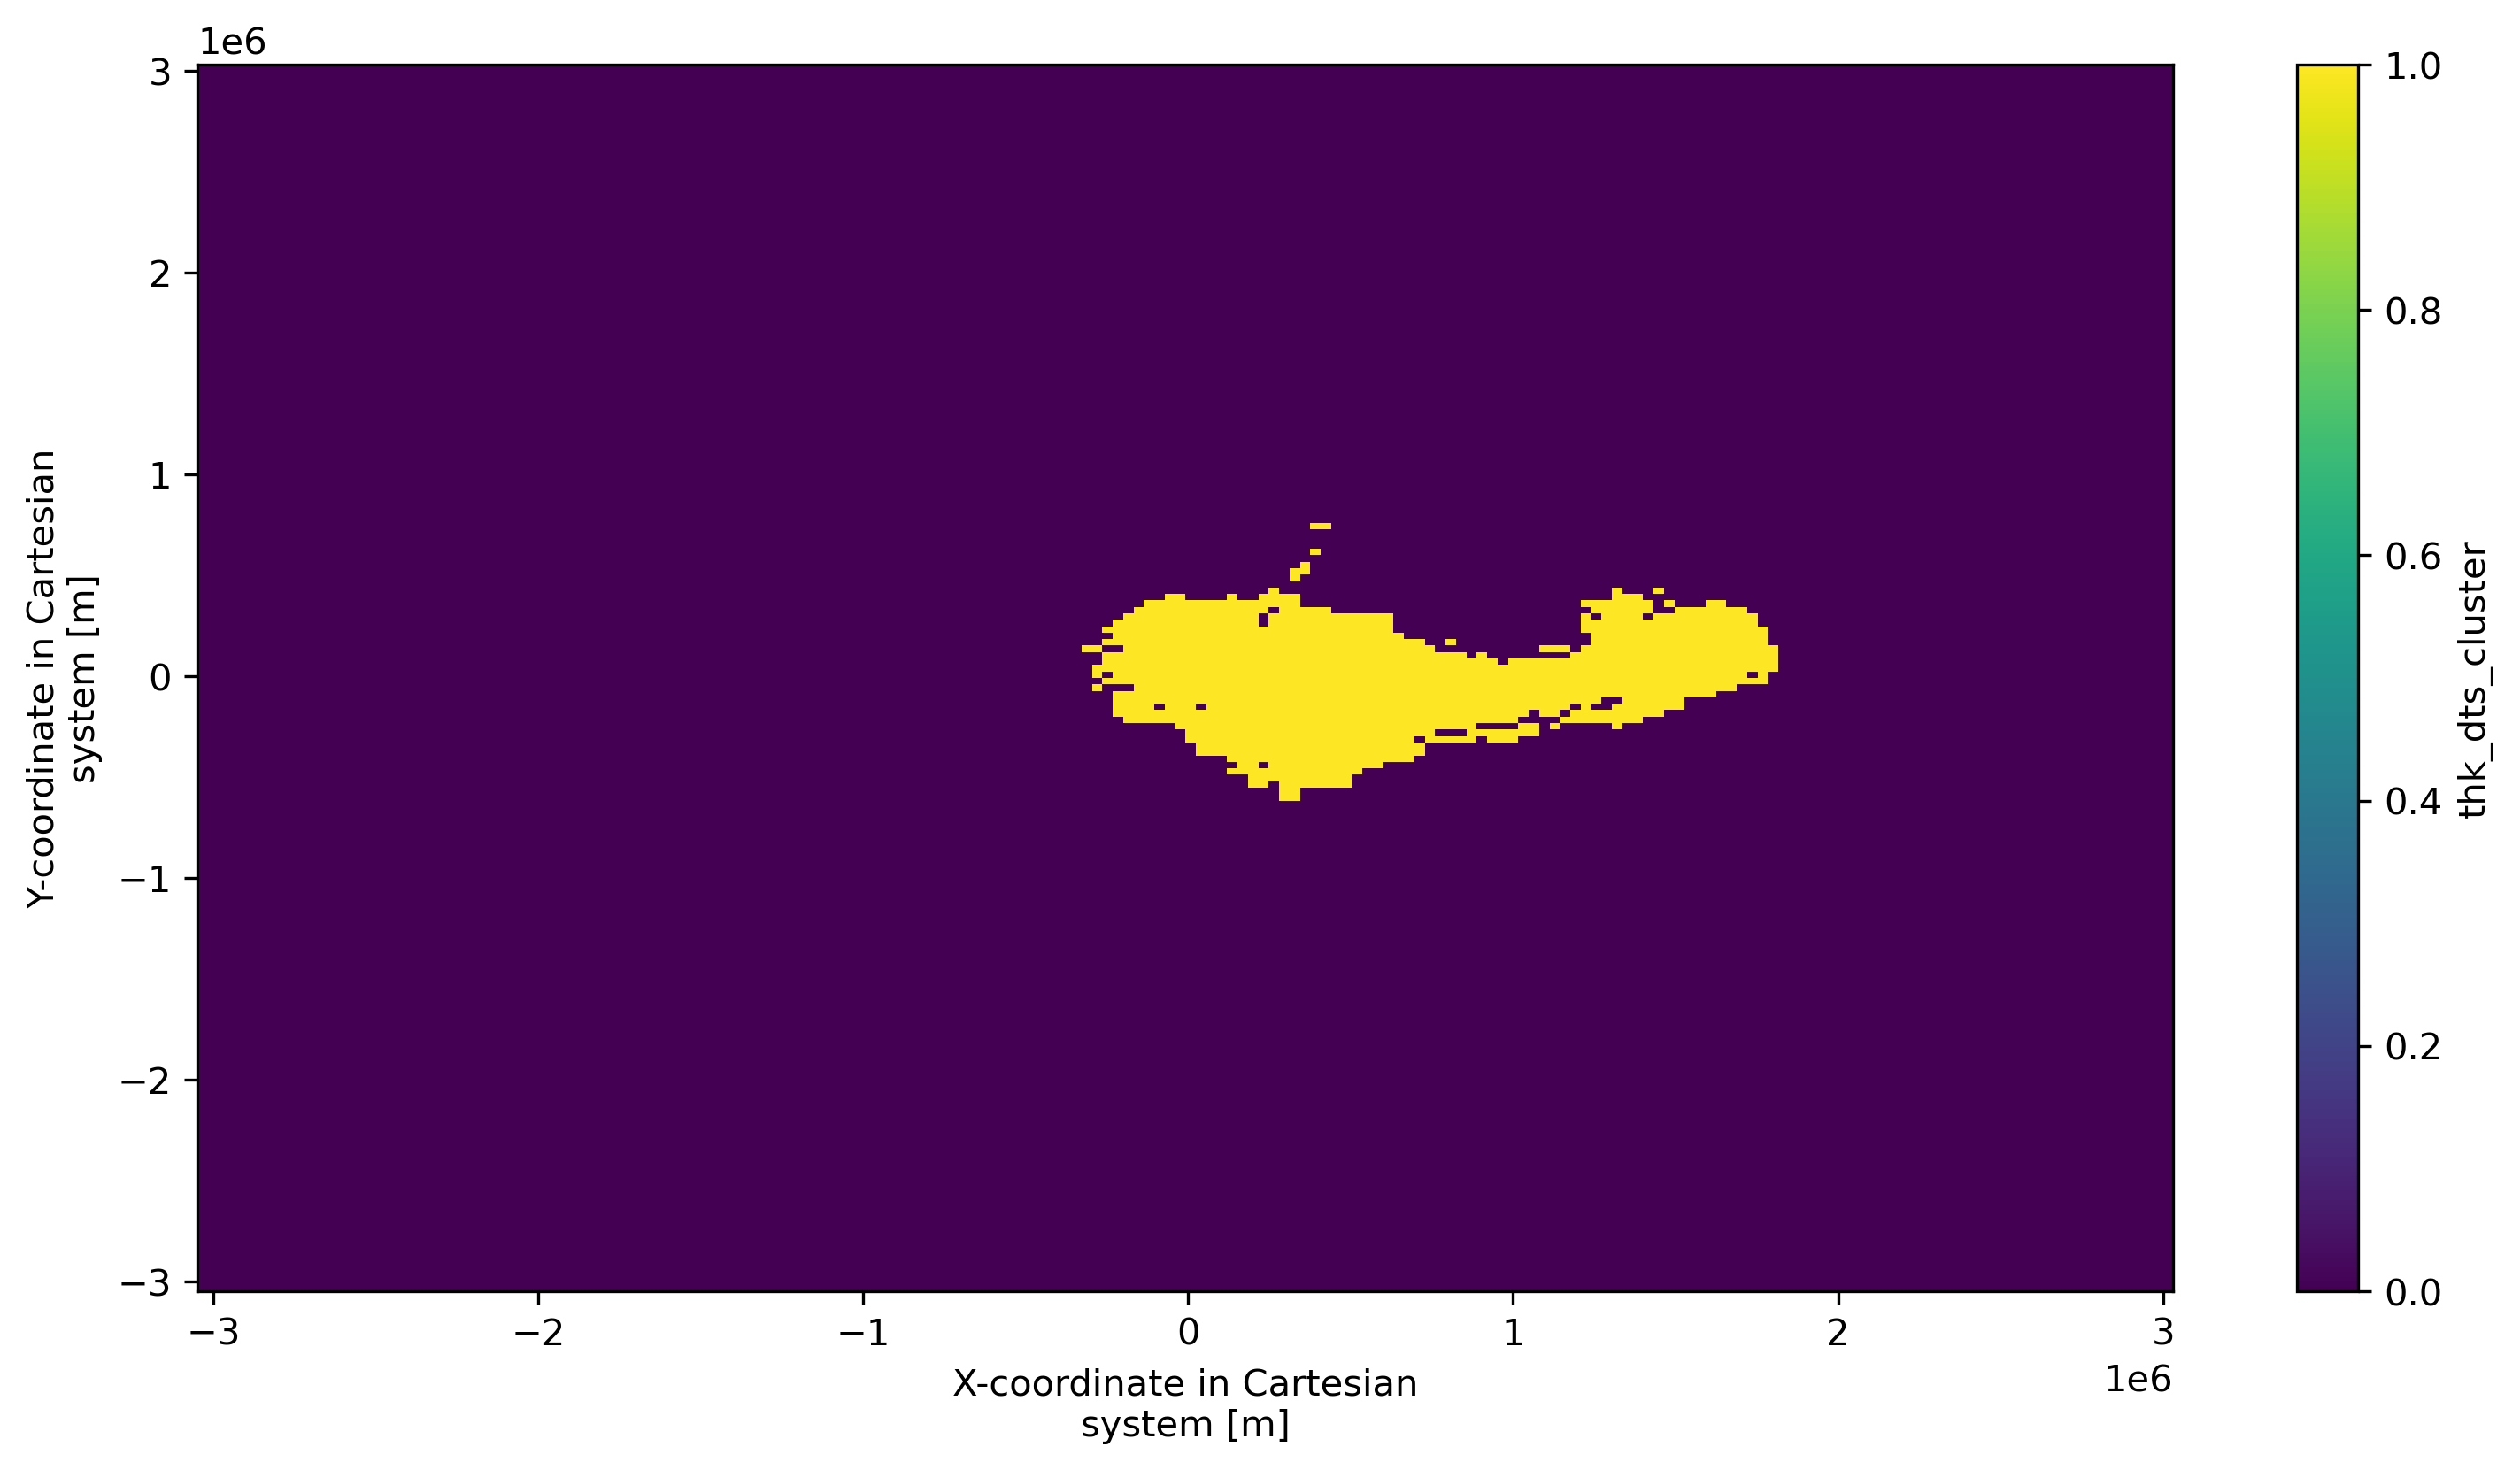

In [25]:
mask.plot()  # type: ignore

#### Access Timeseries in Clusters


Text(0.5, 1.0, 'Cluster 2')

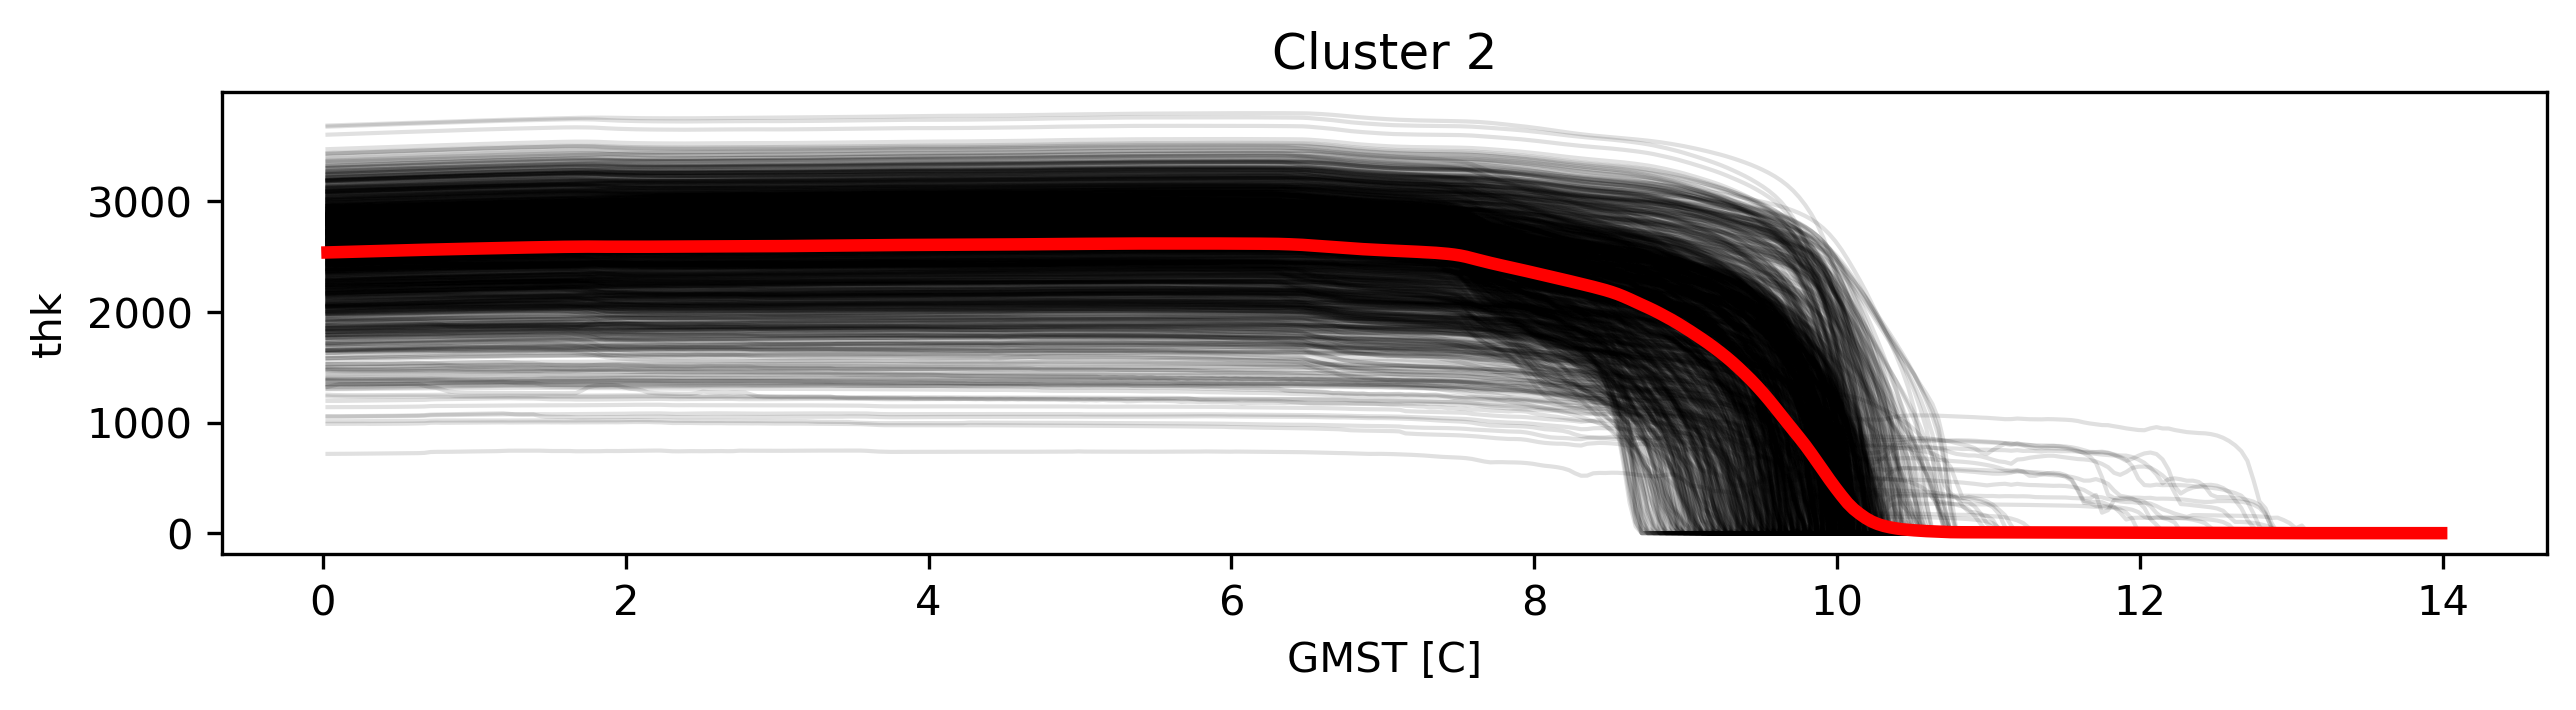

In [26]:
# Get time series from clusters
timeseries = td.get_cluster_timeseries("thk", cluster_id=2)

# get mean of timeseries
mean = td.get_cluster_timeseries("thk", cluster_id=2, aggregation="mean")

# Eg: to plot:
plt.figure(figsize=(10, 2))
for ts in timeseries:
    ts.plot(color="k", alpha=0.12, lw=1)
mean.plot(lw=3, color="r")  # type: ignore
plt.title("Cluster 2")

### Stats

Calling `td.stats(var)` and the submodules `time` and `space` will expose more statistics related helper functions.


#### Time stats


In [27]:
# get start time for cluster 5
td.stats(var="thk").time.start(cluster_id=5)

2.1501

In [28]:
# get all stats in dictionary
td.stats("thk").time.all_stats(5)

{'duration': 0.3600000000000003,
 'duration_timesteps': 9,
 'end': 2.5101000000000004,
 'end_timestep': 62,
 'iqr_50': (2.2701000000000002, 2.3501000000000003),
 'iqr_68': (2.2301, 2.3501000000000003),
 'iqr_90': (2.1901, 2.3501000000000003),
 'mean': 2.314544444444445,
 'median': 2.3101000000000003,
 'membership_peak': 2.2701000000000002,
 'membership_peak_density': 0.005318559556786704,
 'start': 2.1501,
 'start_timestep': 53,
 'std': 0.11066577420434438,
 'steepest_gradient': 2.3101000000000003,
 'steepest_gradient_timestep': 57}

#### Space stats


In [29]:
# Get mean x,y position of cluster 5
td.stats(var="thk").space.mean(cluster_id=5)

(-282661.12266112264, -1269139.293139293)

In [30]:
td.stats("thk").space.all_stats(5)

{'central_point_for_labeling': (-248000.0, -1336000.0),
 'footprint_cumulative_area': 481,
 'footprint_mean': (-282661.12266112264, -1269139.293139293),
 'footprint_median': (-280000.0, -1272000.0),
 'footprint_std': (229008.10144179303, 214851.6466720021),
 'mean': (-282661.12266112264, -1269139.293139293),
 'median': (-280000.0, -1272000.0),
 'std': (229008.101441793, 214851.64667200207)}

#### Cluster scoring

We have a few scores available already that aim to quantify the quality of a cluster.

`score_heaviside()` evaluates how closely the spatially aggregated cluster time series resembles a perfect Heaviside function. A score of 1 indicates a perfect step function, while 0 indicates a linear trend.

`score_consistency()` measures internal coherence using hierarchical clustering. Higher scores indicate more internally consistent clusters, which is useful for assessing cluster quality.

`score_spatial_autocorrelation()` measures average pairwise similarity (R²) between time series within a cluster. Higher scores mean more similar behavior within the cluster. This provides a fast computation of spatial coherence.

`score_nonlinearity()` measures deviation from linearity using RMSE and can be normalized against unclustered data. Higher scores indicate more nonlinear behavior, which is good for detecting complex temporal patterns.


In [31]:
td.stats("thk").general.score_heaviside(5, aggregation="mean")

0.41722873312015085

# Example 2

Let's just try some different data: Mean summer near-surface air temperature.


In [32]:
td2 = TOAD("test_data/global_mean_summer_tas.nc")
td2.data = td2.data.drop_vars(td2.shift_vars)

# Compute shifts
td2.compute_shifts(
    "tas",
    method=ASDETECT(),
)

INFO: New shifts variable tas_dts: min/mean/max=-0.875/0.014/0.979 using 139968 grid cells. Skipped 0.0% grid cells: 0 NaN, 0 constant.


In [33]:
# Compute clusters
td2.compute_clusters(
    "tas",
    method=HDBSCAN(min_cluster_size=20),
)

INFO: New cluster variable tas_dts_cluster: Identified 18 clusters in 13,291 pts; Left 2.5% as noise (329 pts).


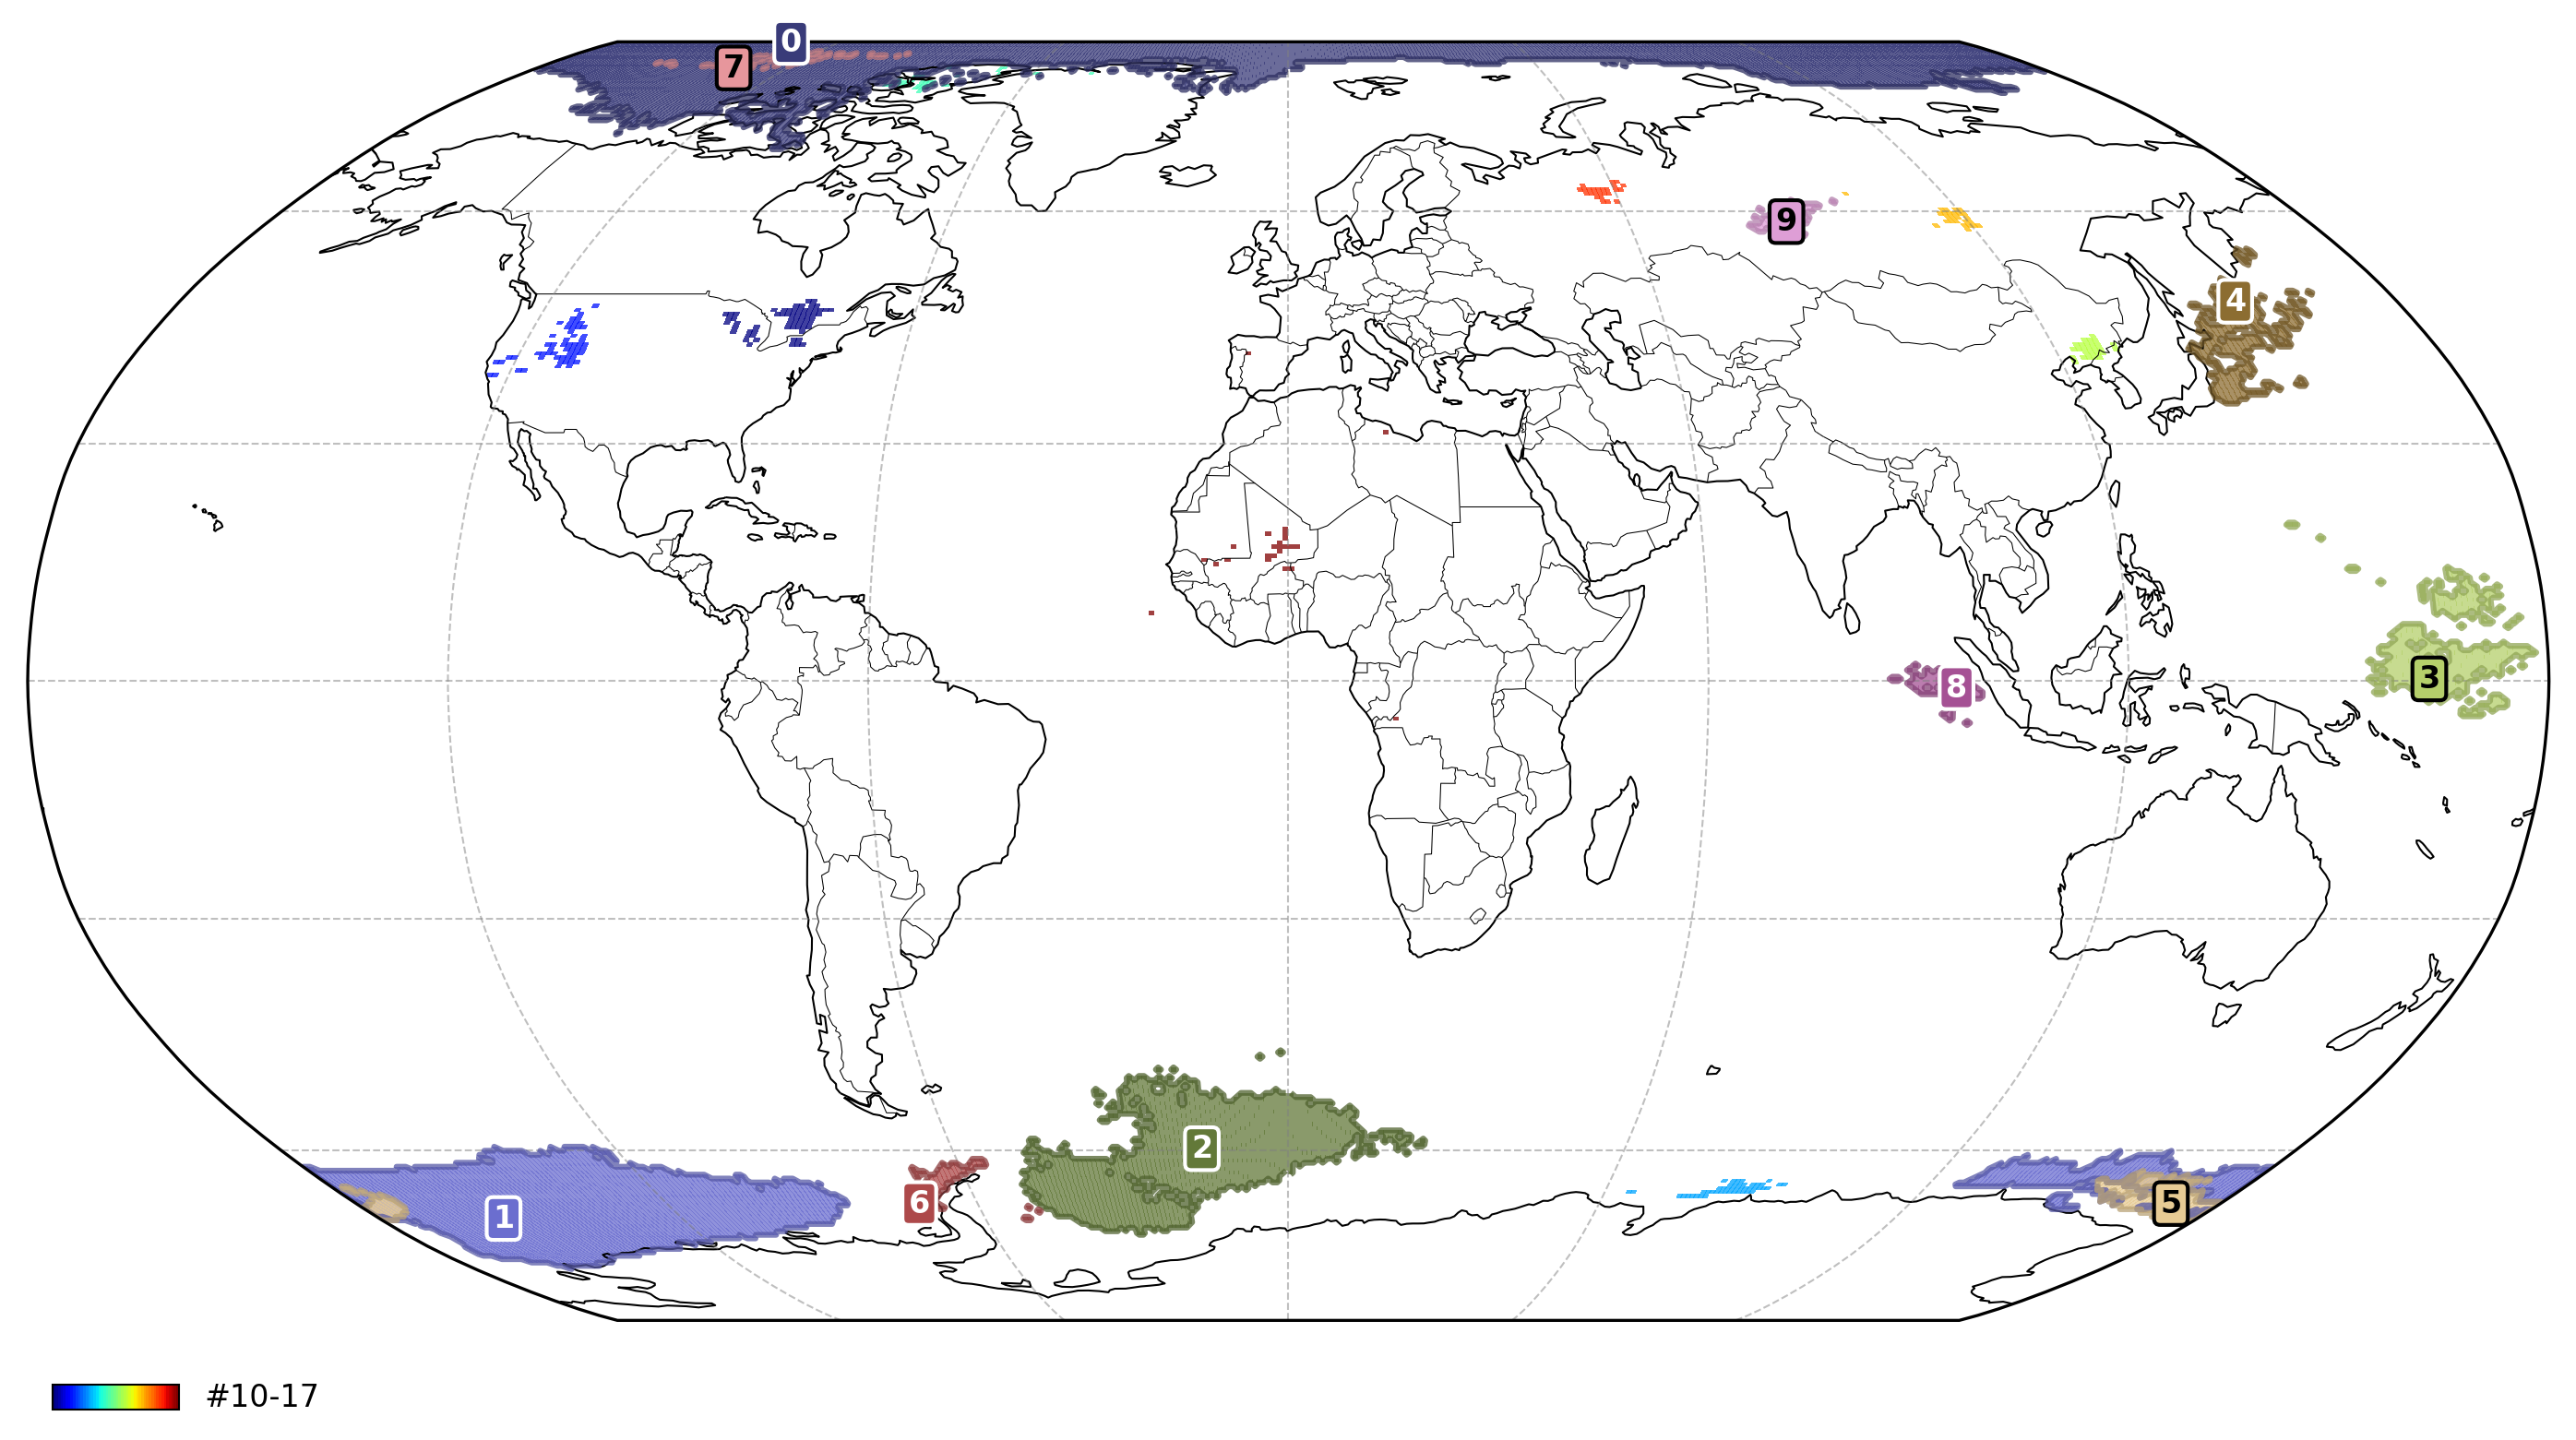

In [34]:
# Plot clusters
td2.plot.cluster_map("tas", cluster_ids=range(10), map_style={"projection": "global"});

# Tip: map style can also be set as a dict, instead of importing the MapStyle class